<a href="https://colab.research.google.com/github/yagippi27/HOSEO_univ./blob/main/Plate_De_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <striong> 1. 초기 세팅 </strong>

- 구글 드라이브 연동
- 필요한 자료 Git에서 클론
- model.weight 다운로드 및 드라이브에 적재
- 사용할 라이브러리 import
- 사용할 이미지 입력 및 확인
- 딥러닝을 위해 사용할 파라미터값을 선언
- 사용 딥러닝 모델 선언

<br>

참고 Github : 
1. [alitourani/yolo-license-plate-detection](https://github.com/alitourani/yolo-license-plate-detection.git)



참고 자료 : 
1. [황선규.(2019.05).OpenCV 4로 배우는 컴퓨터 비전과 머신 러닝. 길벗](https://thebook.io/006939/)
2. [OpenCV-Python Study documentation!](https://opencv-python.readthedocs.io/en/latest/index.html)
3. [코드순례자/OpenCV의 YOLOv3를 사용한 딥 러닝 기반 객체 탐지](https://m.blog.naver.com/PostView.nhn?blogId=tommybee&logNo=221653452583&proxyReferer=https:%2F%2Fwww.google.com%2F)


In [ ]:
## 드라이브 연동
# from google.colab import drive 
# drive.mount('/content/drive')

## yolo-license-plate-detection Git 복제
# !git clone https://github.com/alitourani/yolo-license-plate-detection.git "/content/drive/My Drive/Colab Notebooks/yolo-license-plate-detection"

Mounted at /content/drive


In [ ]:
import cv2 # 이미지 처리 패키지
import numpy as np # 수학 연산 패키지
from google.colab.patches import cv2_imshow # 이미지 확인                                                                                                                                                                                                                                                                                                            

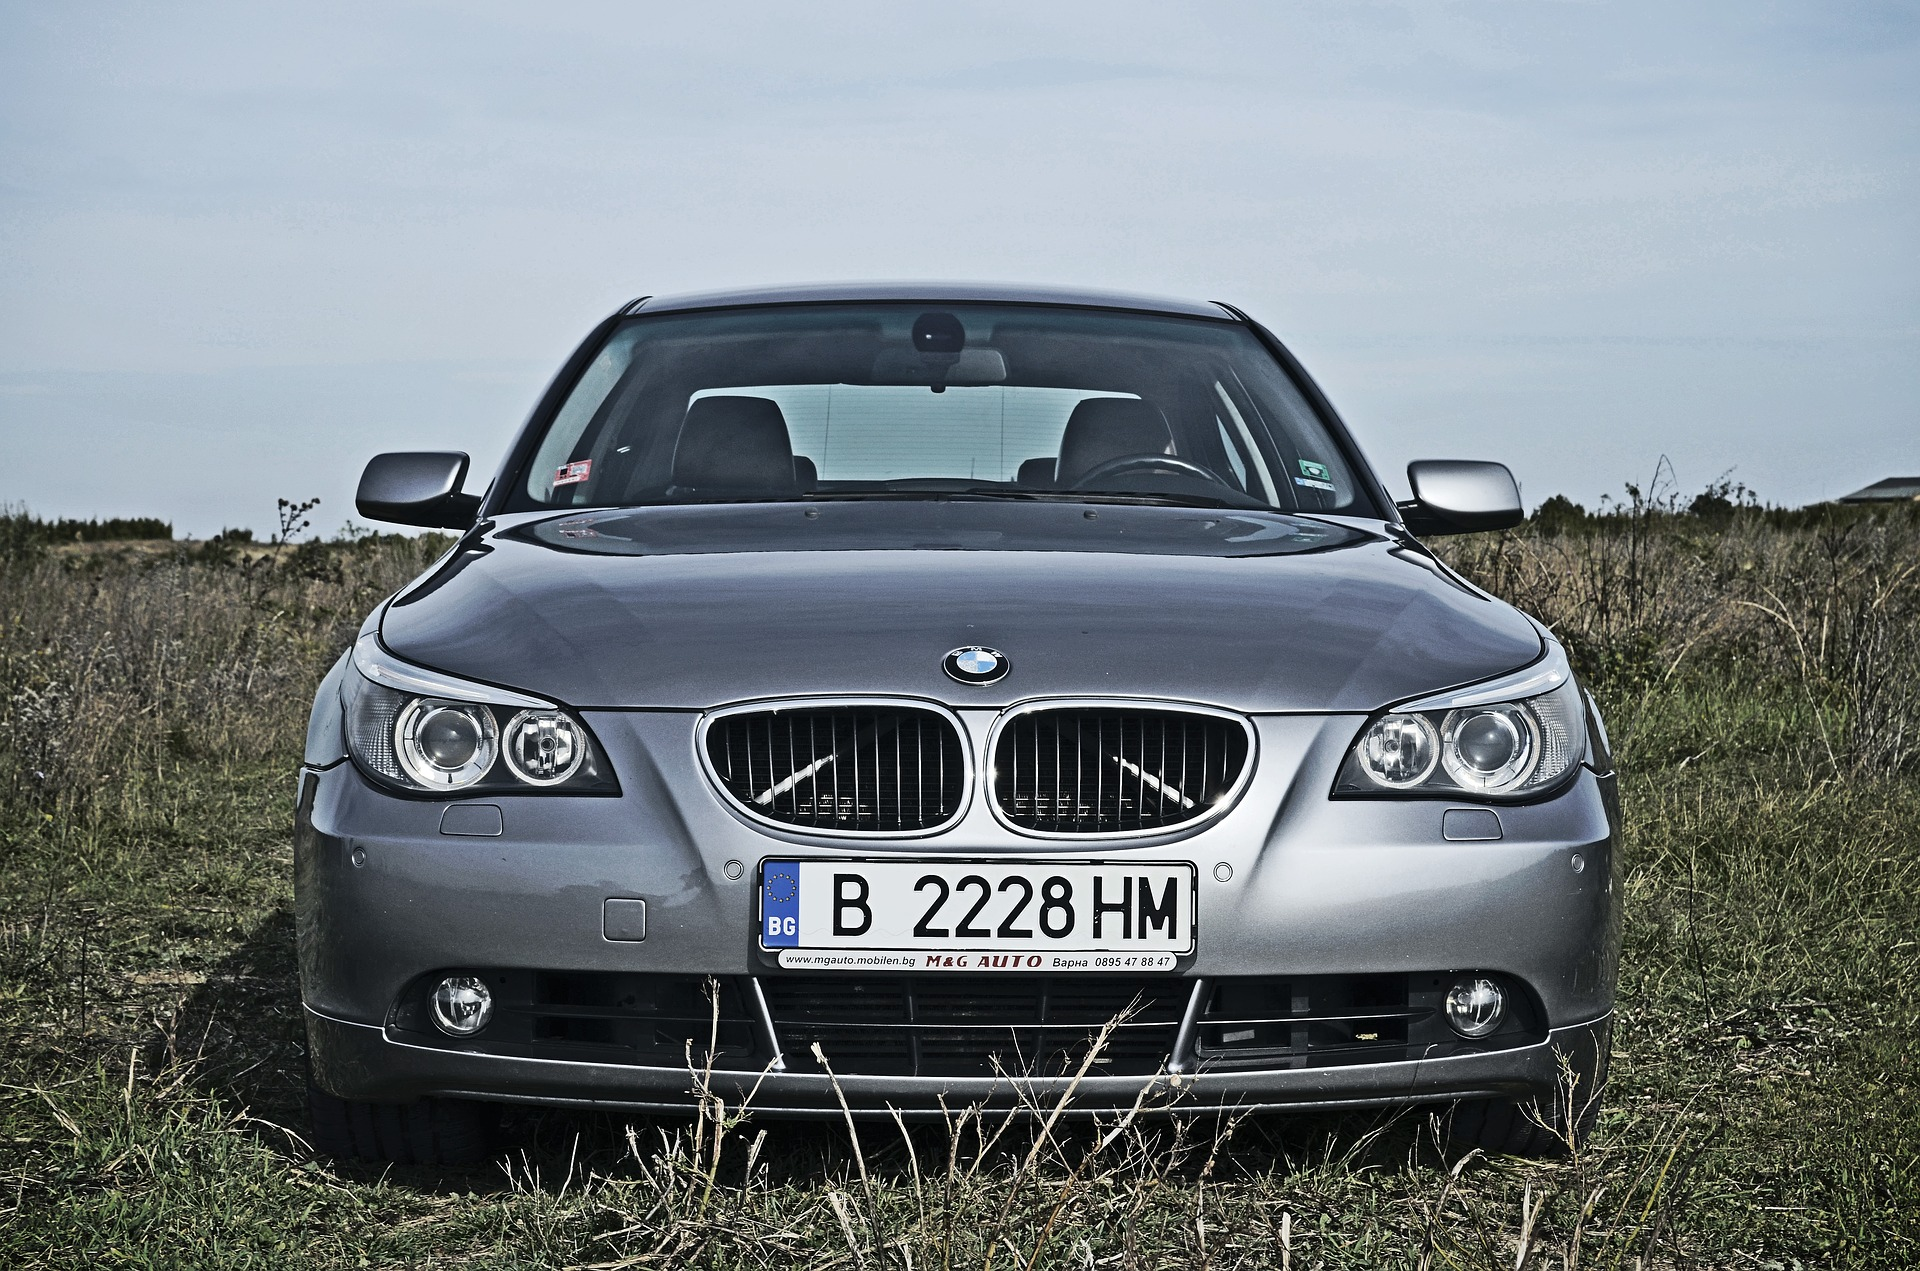

In [ ]:
# 이미지 파일 입력 및 확인
filename = "car2.jpg"
image = "/content/drive/My Drive/Colab Notebooks/★Dataset★/" + filename

test = cv2.imread(image, cv2.IMREAD_COLOR)
cv2_imshow(test)

In [ ]:
# 하이퍼 파라미터 초기값
# 하이퍼 파라미터는 모델링할 때 사용자가 직접 세팅해주는 값
confThreshold = 0.5  # 신뢰도 임계치 Confidence threshold

# 너무 낮게 설정하면(0.1) 겹치는 객체를 감지하지 못하고
# 너무 높게 설정하면(1.0) 같은 객체의 중복 바운딩 박스를 얻음
nmsThreshold = 0.4  # 비최대값 억제 임계치 Non-maximum suppression threshold 

inpWidth = 416  # 네트워크 입력 너비 # 320(빠른 결과), 416(디폴트), 608(정확한 결과) 가능
inpHeight = 416 # 네트워크 입력 높이 # 320(빠른 결과), 416(디폴트), 608(정확한 결과) 가능

In [ ]:
# 훈련된 가중치가 저장된 model 파일과 네트워크 구조를 표현하는 config 파일 불러오기

modelWeights = "/content/drive/My Drive/Colab Notebooks/yolo-license-plate-detection/model.weights"
modelConfiguration = "/content/drive/My Drive/Colab Notebooks/yolo-license-plate-detection/darknet-yolov3.cfg"


# opencv에서 사용할 수 있는 dnn(deep neural network) 중 하나인 Darknet을 사용
# readNetFromDarknet() 함수를 사용하여 사용자가 직접 호출할 수도 있으나, 
# OpenCV 4.0.0버전부터는 readNet() 대표함수를 사용하는 것을 권장

# readNet(String&model, String&config = ””, String& framework = ””)
# String&model ->  model 파일
# String&config -> 네트워크 구조를 표현하는 config 파일
# framework -> 	명시적인 딥러닝 프레임워크 이름
net = cv2.dnn.readNet(model=modelWeights, config=modelConfiguration, framework="darknet") 

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV) # 선호하는 백엔드를 지정
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU) # 선호하는 타깃 디바이스를 지정

##<strong> 2. 필요한 함수 정의 </strong>

```
def 함수이름(매개변수): # 첫 행. 매개변수는 필수적이지 않음
    본문                # 함수를 호출했을 때 실행할 코드 블록
```
위와 같은 형식으로 함수를 정의한다.


In [ ]:
# OpenCV의 forward 함수에는 네트워크에서 어디까지 실행할지를 알려주는 끝 레이어의 정보가 필요
# 출력 레이어의 이름 가져오기
def getOutputsNames(net):
    # 네트워크에 있는 모든 레이어의 이름 가져오기
    layersNames = net.getLayerNames()
    # 연결되어 있지 않은 출력 레이어(네트워크의 마지막 레이어)의 이름을 가져옴
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# 자동차 번호판으로 예상되는 부분을 모자이크 처리
def blur_out(classId, conf, left, top, right, bottom):
  # print('left= ', left, 'top= ', top, 'right= ', right, 'bottom= ', bottom)

  car_img = frame[top:bottom, left:right]
  shrink = cv2.resize(car_img, None, fx=0.05, fy=0.05)
  zoom = cv2.resize(shrink, (right-left, bottom-top), interpolation=cv2.INTER_AREA)
  frame[top:bottom, left:right] = zoom

In [ ]:
# 후처리 단계
# 비최대값 억제 방법(non-maxima suppression)을 이용하여 낮은 신뢰도를 가진 바운딩 박스를 제거하기

def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    # 네트워크를 통해 나오는 모든 바운딩 박스를 훑어보고 높은 점수를 가진 바운딩 박스만 남김.
    # 그리고 가장 신뢰도 점수가 높은 클래스로 바운딩 박스의 클래스 값이 할당
    classIds = []
    confidences = []
    boxes = []

    for out in outs:
        print("out.shape : ", out.shape)
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if detection[4] > confThreshold:
                print(detection[4], " - ", scores[classId],
                      " - th : ", confThreshold)
                print(detection)
            if confidence > confThreshold:
                # 네트워크 출력 경계 상자는 각각 클래스 수 + 5개 요소로 구성된 벡터로 표시
                # 5개 요소 : center_x, center_y, width, height 그리고 confidences
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])


    # 비최대값 억제 방법(non-maxima suppression)을 통해 낮은 신뢰도를 가진 불필요한 중복 바운딩 박스를 제거하기
    # NMSBoxes(bboxes, scores, score_threshold, nms_threshold[, eta[, top_k]])
    # bboxes -> NMS를 적용시킬 바운딩 박스
    # score -> 네트워크를 통해 나오는 점수
    # score_threshold -> 신뢰도 임계치 Confidence threshold
    # nmsThreshold -> 비최대값 억제 임계치
    indices = cv2.dnn.NMSBoxes(bboxes = boxes, scores = confidences, score_threshold = confThreshold, nms_threshold = nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        blur_out(classIds[i], confidences[i], left,top, left + width, top + height)

##<strong> 3. 모델 실행 및 결과 보기</strong>

In [ ]:
# 이미지 읽기
frame = cv2.imread(image)

# 현재 지정한 하이퍼 파라미터만 톺아보기

# 네트워크 입력으로 Mat 타입의 2차원 영상을 그대로 입력하는 것이 아니라 블롭(blob) 형식으로 변경해야 함.
# 블롭이란 영상 등의 데이터를 포함할 수 잇는 다차원 데이터 표현 방식
# OpenCV에서 블롭은 Mat타입의 4차원 행렬로 표현됨
# 각 차원은 N(영상개수), C(채널개수), H(영상의 세로 크기), W(영상의 가로 크기)를 의미함
# OpenCV에서는 blobFromImage() 함수를 이용하여 Mat 영상으로부터 블롭을 생성함.

# 네트워크 입력을 위해 데이터 형식을 바꾸기
# blobFromImage(image, scalefactor=1.0, Size&size=Size(), Scalar&mean=Scalar(), swapRB=false, crop=false)
# image -> 입력 영상. 1 또는 3 또는 4채널
# scalefactor -> 입력 영상 픽셀 값에 곱할 값 e.g. scalefactor = 1/255 는 모든 픽셀 값을 0에서 1로 만들겠다는 것
# Size&size -> 출력 영상의 크기
# Scalar&mean -> 입력 영상 각 채널에서 뺄 평균값. 만약 image가 BGR 채널 순서이고 swapRB가 true이면 (R 평균, G 평균, B 평균) 순서로 값을 지정
# swapRB -> 첫 번째 채널과 세 번째 채널을 서로 바꿀 것인지를 결정하는 플래그. 이 값이 true이면 컬러 입력 영상의 채널 순서를 BGR에서 RGB로 변경
# crop -> 입력 영상의 크기를 변경한 후, 크롭(crop)을 수행할 것인지를 결정하는 플래그
blob = cv2.dnn.blobFromImage(frame, scalefactor = 1/255, size = (inpWidth, inpHeight), mean = [0, 0, 0], swapRB = False, crop=False)

# 블롭 객체를 네트워크 입력으로 설정하기
# setInput(blob)
# blob -> 블롭 객체.
net.setInput(blob)

# 위의 setInput() 함수로 설정한 입력 블롭을 이용하여 네트워크를 실행하고, outputName에 해당하는 레이어에서의 결과를 Mat 객체로 반환
# forward(outputName)
# outputName -> 출력 레이터 이름
outs = net.forward(getOutputsNames(net))

# Remove the bounding boxes with low confidence
postprocess(frame, outs)

out.shape :  (507, 6)
out.shape :  (2028, 6)
0.9928322  -  0.9920811  - th :  0.5
[0.51981765 0.7094241  0.21705088 0.07381848 0.9928322  0.9920811 ]
out.shape :  (8112, 6)


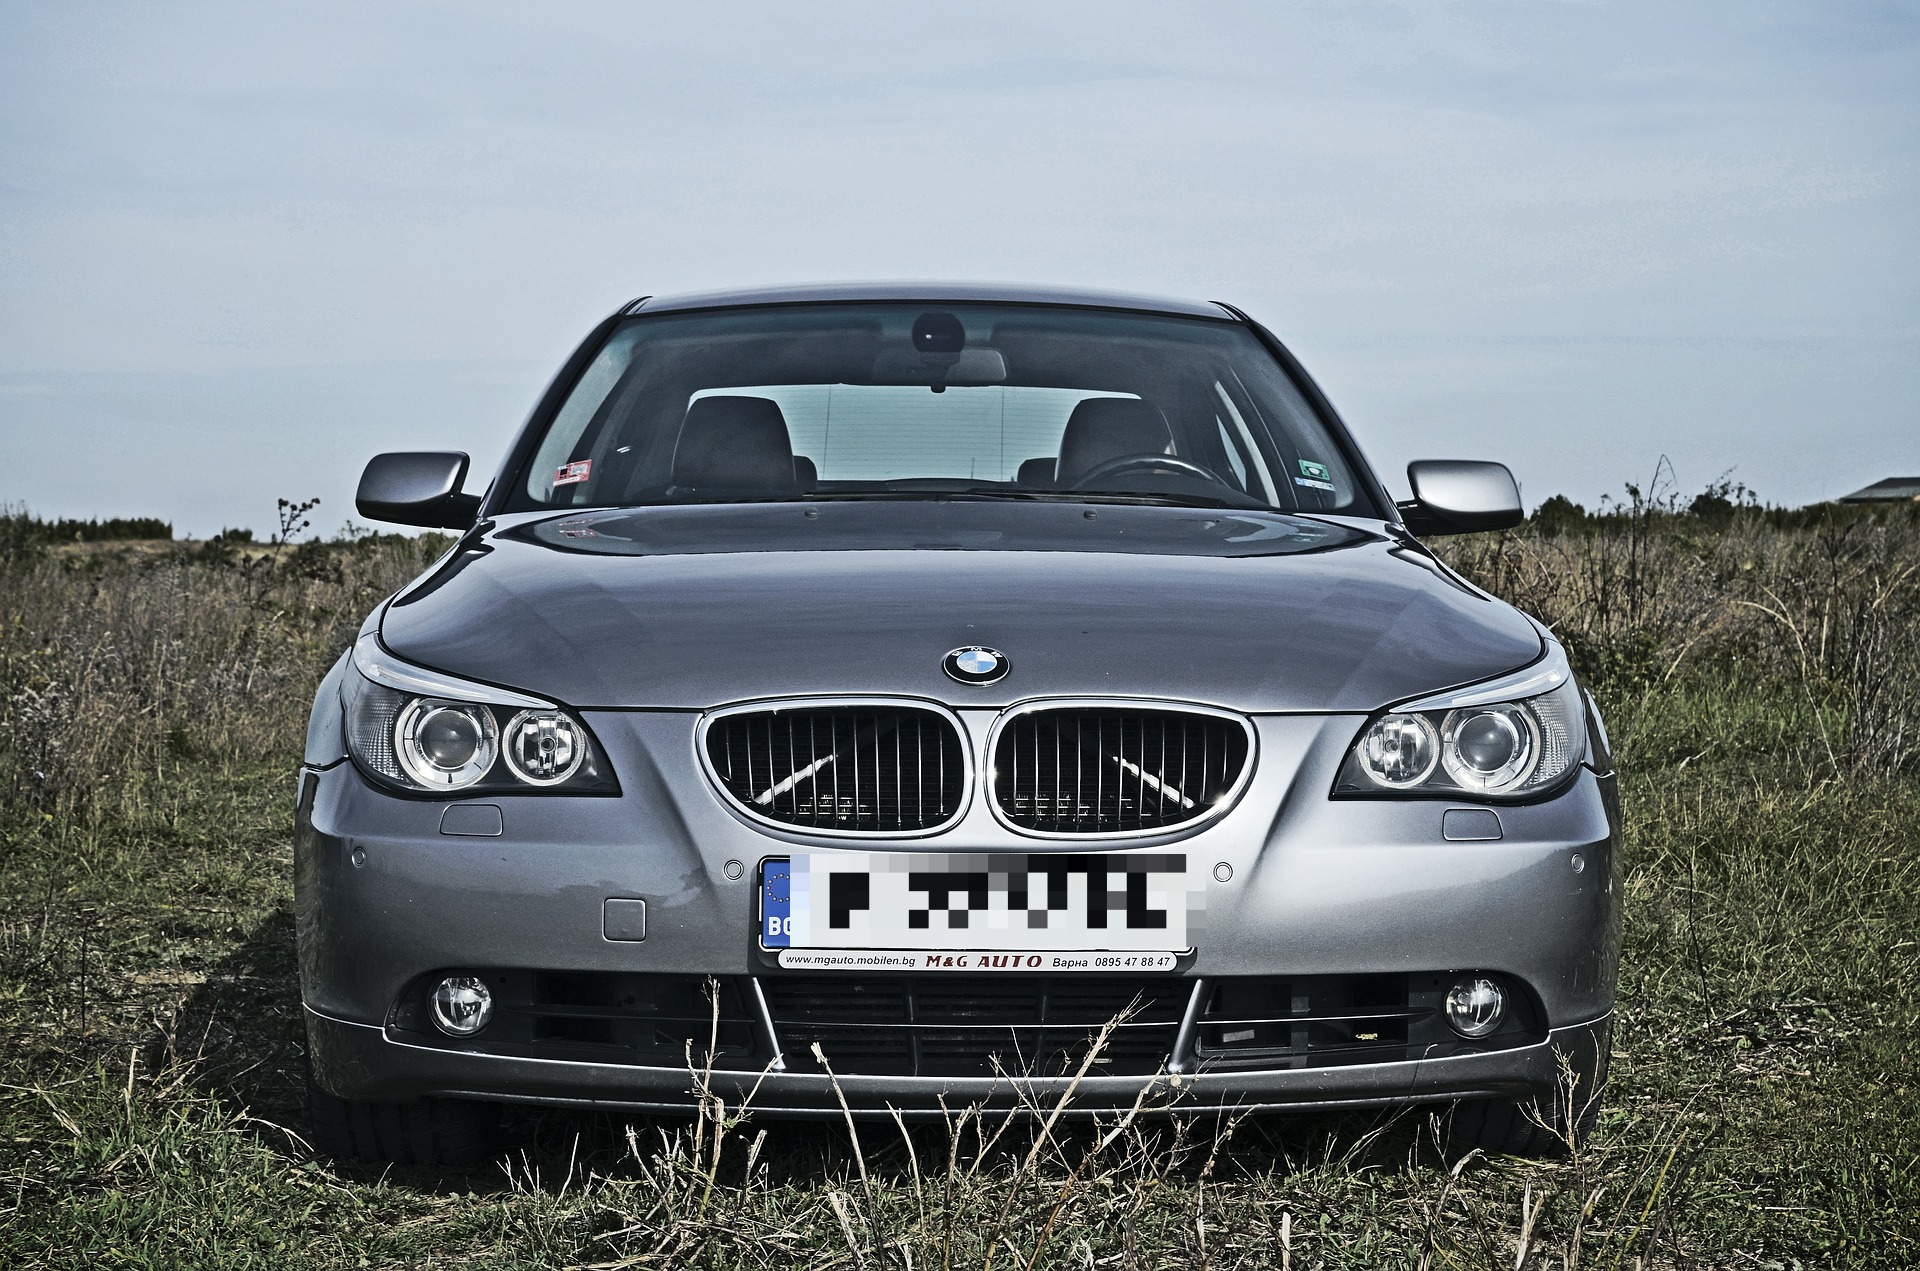

In [ ]:
cv2_imshow(frame.astype(np.uint8))